# HW6 Neural Nets

By Maia Rosengarten <br/>
SID: 23572580 <br/>
April 14, 2017

In [329]:
import matplotlib
import numpy as np
from numpy import linalg as LA
import matplotlib.cm as cm
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import math
import scipy as sp
from scipy import io
from scipy.stats import logistic as sig
import pandas as pd

np.set_printoptions(threshold=np.nan)

import sklearn
from sklearn.preprocessing import normalize
import csv
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle as shuffle
from sklearn.utils import resample as resample
from sklearn.preprocessing import StandardScaler
%matplotlib inline

# NP FNS

In [330]:
def vec(arr): # d b 1 --> (d, 1)
    return arr.reshape((arr.shape[0], 1))

In [331]:
def arr(vec): # 1 by d --> (d, )
    return vec.flatten()

# UTIL FNS

In [332]:
def plotAccuracies(accuracies, depths):
    '''
        Plots accuracies as a function od depth
        Args:
            costs (ndarray) - lst of costs per iteration of gradient descent
    '''
   
    plt.plot(depths, accuracies)
    plt.title("Prediction Evaluation Decision Tree On Census Data")
    plt.xlabel('max_depth')
    plt.ylabel('accuracy')
    plt.show()

In [333]:
def plotCosts(costs, iterations):
    '''
        Plots accuracies as a function od depth
        Args:
            costs (ndarray) - lst of costs per iteration of gradient descent
    '''
   
    plt.plot(iterations, costs)
    plt.title("Costs")
    plt.xlabel('costs')
    plt.ylabel('numIter')
    plt.show()

In [350]:
def generateCsv(aryPredictions, strCsvName):
    '''
    Writes predictions of testSet to csv file
    Args:
        aryPredictions (ndarray) - (nx1)-array of predictions given size n test (or valid) set
        strCsvName (str) - name of csv file to write to
    '''
    with open(strCsvName + '.csv', 'w') as csvfile:
        writer = csv.writer(csvfile)
        for i in range(len(aryPredictions)):
            writer.writerow([i, aryPredictions[i]])
    csvfile.close()

# Training

In [335]:
class NeuralNet:
    def __init__(self, trainX, trainY, V=None, W=None, l2=None, numHiddenLayers=800, learnRateW=0.01, learnRateV=0.01, hasDecay=True, hasDropOut=False, momentum=None, batchSize=None, numIterations=10000):
        self.X = trainX
        self.Y = trainY
        self.sizeH = numHiddenLayers
        self.learnRateW = learnRateW
        self.learnRateV = learnRateV
        self.hasDecay = hasDecay
        self.hasDropOut = hasDropOut
        self.momentum = momentum
        self.batchSize = batchSize
        self.numIter = numIterations
        self.V = V 
        self.W = W
        self.predictions = []
        self.l2 = l2
        self.costs = []
        if V==None and W==None:
            self.initWeights()
    
    def setLearningRates(self, learnRateW, learnRateV):
        self.learnRateW = learnRateW
        self.learnRateV = learnRateV
    
    def setWeights(self, W, V):
        self.V = V
        self.W = W
    
    def setHasDecay(self, hasDecay):
        self.hasDecay = hasDecay
    
    def setMomentum(self, momentum):
        self.momentum = momentum
    
    def initWeights(self):
        numFeatures = self.X.shape[1]
        self.V = np.random.normal(loc=0.0, scale=1/np.sqrt(numFeatures), size=(self.sizeH, numFeatures))
        self.W = np.random.normal(loc=0.0, scale=1/np.sqrt(self.sizeH + 1), size=(26, self.sizeH + 1))
#         self.V = np.random.normal(loc=0.0, scale=0.01, size=(self.sizeH, numFeatures))
#         self.W = np.random.normal(loc=0.0, scale=0.01, size=(26, self.sizeH + 1))
    
    def trainSGD(self):
        epoch = self.X.shape[0]
        numFeatures = self.X.shape[1]
        for i in range(self.numIter):   
            index = i%epoch
            if (index==0 and i!=0):
                self.X, self.Y = shuffle(self.X, self.Y, random_state=42)
            
            sample = vec(self.X[index])
            y = vec(self.Y[index])
            
            if self.hasDropOut and i%10000==0:
                inputDropOutIndices = np.random.choice(range(0, numFeatures), size=math.ceil(0.10*numFeatures), replace=False)
                hiddenDropOutIndices = np.random.choice(range(0, self.sizeH), size=math.ceil(0.5*self.sizeH), replace=False)
                sample[inputDropOutIndices]=0 
                h = np.tanh(np.dot(self.V.T, sample)) 
                h[hiddenDropOutIndices]=0
            else:
                h = np.tanh(np.dot(self.V, sample)) 
            h = np.vstack((h, np.array(1)))
            z = sp.special.expit(np.dot(self.W, vec(h)))
            grad_w = grad = np.dot(z-y, h.T)           
            diag = np.diag(arr(np.dot((z-y).T, W)))
            dLdH = 1-np.square(arr(h))
            grad_v = np.dot(np.dot(diag.T, vec(dLdH)), sample.T)[:-1]
            
            if self.hasDecay and i%50000==0:
                self.learnRateW = 0.001
                self.learnRateV = 0.001
            
            self.W = self.W - self.learnRateW * grad_w
            self.V = self.V - self.learnRateV * grad_v
            self.costs.append(computeCrossEntropyLoss(z, y))
        return self.V, self.W

    def trainMiniBatch(self):
        epoch = self.X.shape[0]
        t = 0
        
        while t < self.numIter:
            if (t%20000==0):
                print('iter ' + str(t))        
            i = t % epoch
            j = (t + self.batchSize) % epoch

            if (t==epoch):
                self.X, self.Y = shuffle(self.X, self.Y, random_state=42)
                i = 0
                j = self.batchSize
            else:
                i = t % epoch
                j = (t + self.batchSize) % epoch 
            
            samples = self.X[i:j]
            y = self.Y[i:j]
  
            if self.hasDropOut:
                numFeatures = self.X.shape[1]
                inputDropOutIndices = np.random.choice(range(numFeatures), size=math.ceil(0.10*numFeatures), replace=False)
                hiddenDropOutIndices = np.random.choice(range(self.sizeH), size=math.ceil(0.5*self.sizeH), replace=False) 
                samples.T[inputDropOutIndices]=0
                h = np.tanh(np.dot(self.V, samples.T)) 
                h[hiddenDropOutIndices]=0
            else:
                h = np.tanh(np.dot(self.V, samples.T)) 
            
            h = np.vstack((h, np.array([1]*h.shape[1])))
            z = sp.special.expit(self.W.dot(h)) 
            zMinusY = (z-y.T)   
            if (self.l2):
                reg = 2*self.l2
                grad_w = np.dot(zMinusY, h.T) + reg*self.W
                grad_v = np.multiply(((zMinusY.T).dot(self.W)).T, 1-h**2).dot(samples)[:-1] + reg*self.V
            else:
                grad_w = zMinusY.dot(h.T)
                grad_v = np.multiply(((zMinusY.T).dot(self.W)).T, 1-h**2).dot(samples)[:-1]
                
            if self.hasDecay and t%50000==0 and t!=0:
                self.learnRateW = 0.001
                self.learnRateV = 0.001
                
            self.W = self.W - (self.learnRateW * grad_w)
            self.V = self.V - (self.learnRateV * grad_v)
            self.costs.append(self.computeCrossEntropyLossBatch(z, y))
            
            t+=self.batchSize
            
        return self.V, self.W

    
    def plotCosts(self, costs, iterations, strTypeGradDescent="MiniBatch"):
        '''
            Plots accuracies as a function od depth
            Args:
                costs (ndarray) - lst of costs per iteration of gradient descent
        '''

        plt.plot(iterations, costs)
        plt.title("Costs " + strTypeGradDescent)
        plt.xlabel('iterations')
        plt.ylabel('costs')
        plt.show()
    
    def computeCrossEntropyLossBatch(self, z, y):
        '''
            y: (50x26)
            z: (26x50)
            ret: (1x1)
        
        '''
        cost = np.multiply(y, np.log(z.T + 0.001))
        return np.sum(-cost) * 1/self.batchSize
    
    def predict(self, testX):
        sizeData = testX.shape[0]
        self.predictions = []
        for i in range(sizeData):
            if (i%(sizeData/2)==0 and i!=0):
                print('halfway point')     
            h = np.tanh(np.dot(self.V, vec(testX[i])))
            h = np.vstack((h, np.array(1)))
            z = sp.special.expit(self.W.dot(h))
            prediction = np.argmax(z)
            self.predictions.append(prediction+1)
        return self.predictions


a) We need to solve for two gradients, one in the update equation for W: <br/>

$\begin{equation}
W_{t} = W_{t-1} - \epsilon(\nabla_{W}L) \\
\end{equation}$

and the other in the update equation for V:

$\begin{equation}
V_{t} = V_{t-1} - \epsilon(\nabla_{V}L) \\
\end{equation}$

where $\epsilon$ is the step size and L is the cross entropy loss function.</br><br/>

Let's solve for the first gradient. We'll do so in terms of $W_j$, the (1x201) rows in matrix W before writing the expression in terms of W, a (26x201) matrix. Let $z_j$ be the $j^{th}$ component of the output layer (where z is the (26x1) sigmoid vector-function applied to Wh. Let $h_j$ be the $j^{th}$ component of the hidden layer, where h is the tanh activation function applied to $Vx$. V is a (200x785) matrix and x is (785x1) vector, making h a (201 x 1)-vector, including the bias term. <br/> <br/>
\begin{align}
\frac{\partial L}{\partial W_j} &= \frac{\partial L}{\partial z_j} \frac{\partial z_j}{\partial W_j} \\
\frac{\partial z_j}{\partial W_j} &= z_j(1-z_j)h \\
\frac{\partial L}{\partial z_j} &= \frac{1-y_j}{1-z_j} - \frac{y_j}{z_j}\\
\frac{\partial L}{\partial z_j} \frac{\partial z_j}{\partial W_j} &= (\frac{1-y_j}{1-z_j} - \frac{y_j}{z_j})(z_j(1-z_j)h)\\
&= ((1-y_j)z_j - y_j(1-z_j))h^T \\
&= (z_j - y_jz_j - y_j +y_jz_j)h^T\\
&= (z_j - y_j)h^T\\
\text{Therefore in terms of W}:\\
\frac{\partial L}{\partial W} &= (z-y)h^T
\end{align}

<br/>
Now we can solve for the second gradient, first in terms of $V_j$, the $j^{th}$ row of the matrix V before writing the expression in terms of V, a (200x785) matrix:<br/>
\begin{align}
\frac{\partial L}{\partial V_j} &= \frac{\partial L}{\partial h_j}\frac{\partial h_j}{\partial V_j}\\
\frac{\partial L}{\partial h_j} &= \sum_{i=1}^{26}{\frac{\partial L}{\partial z_i}\frac{\partial z_i}{\partial h_j}}\\
 &= \sum_{i=1}^{26}{\frac{\partial L}{\partial z_i}z_i(1-z_i)W_{ij}}\\
&= \sum_{i=1}^{26}{(\frac{1-y_i}{1-z_i} - \frac{y_i}{z_i})z_i(1-z_i)W_{ij}}\\
&= \sum_{i=1}^{26}{(z_i - y_i)W_{ij}}\\
\text{In terms of the vector h, }\\
\frac{\partial L}{\partial h} &= \sum_{i=1}^{26}{(z_i - y_i)W_{i}^T}\\
\text{We can solve for the next term similarly,}\\
\frac{\partial h_j}{\partial V_j} &= 1-tanh^2(V_jx)x^T\\ 
\text{And in terms of the matrix V, }\\
\frac{\partial h}{\partial V} &= (1-tanh^2(Vx))x^T\\ 
\text{Therefore,}\\
\frac{\partial L}{\partial V} &= \frac{\partial L}{\partial h}\frac{\partial h}{\partial V} \\
&=(\sum_{i=1}^{26}{(z_i - y_i)W_{i}^T})*(1-tanh^2(Vx))(x^T)\\ 
\end{align}
<br/>
In the last step we perform an element-wise multiplication between the first and second terms $(\sum_{i=1}^{26}{(z_i - y_i)W_{i}^T})*(1-tanh^2(Vx))$ so that we get a (201x1) vector. We can then take the dot product with $x^T$ to get a (201x785) matrix. Because we would like $\frac{\partial L}{\partial V}$ to be a (200x785) matrix we can remove the last column by returning $\frac{\partial L}{\partial V}[:-1]$ as our gradient.


In [328]:
dictLetters = sp.io.loadmat("hw6_data_dist/letters_data.mat")

In [344]:
train_x = dictLetters['train_x']
train_y = dictLetters['train_y']
test_x = dictLetters['test_x']
scaler = StandardScaler()
normalizer = scaler.fit(train_x)
train_x = normalizer.transform(train_x)
test_x = normalizer.transform(test_x)

train_x, train_y = shuffle(train_x, train_y, random_state=42)

train_x, valid_x, train_y, valid_y = train_test_split(train_x, train_y, test_size=.2, random_state=42)

train_x = np.hstack((train_x, np.ones(shape=(train_x.shape[0], 1))))
valid_x = np.hstack((valid_x, np.ones(shape=(valid_x.shape[0], 1))))
test_x = np.hstack((test_x, np.ones(shape=(test_x.shape[0], 1))))

one_hot_train_y = pd.get_dummies(arr(train_y)).as_matrix()

/Users/maialena/anaconda/envs/189hw/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


In [336]:
net = NeuralNet(train_x, one_hot_train_y, l2=0.04, hasDecay=True, numHiddenLayers=800, batchSize=40, numIterations=1000000)

In [337]:
V, W = net.trainMiniBatch()

iter 0
iter 20000
iter 40000
iter 60000
iter 80000
iter 100000
iter 120000
iter 140000
iter 160000
iter 180000
iter 200000
iter 220000
iter 240000
iter 260000
iter 280000
iter 300000
iter 320000
iter 340000
iter 360000
iter 380000
iter 400000
iter 420000
iter 440000
iter 460000
iter 480000
iter 500000
iter 520000
iter 540000
iter 560000
iter 580000
iter 600000
iter 620000
iter 640000
iter 660000
iter 680000
iter 700000
iter 720000
iter 740000
iter 760000
iter 780000
iter 800000
iter 820000
iter 840000
iter 860000
iter 880000
iter 900000
iter 920000
iter 940000
iter 960000
iter 980000


# Validation Accuracy

In [338]:
predictions = net.predict(valid_x)

halfway point


In [339]:
accuracy = accuracy_score(predictions, valid_y)
accuracy

0.89619391025641026

# Training Accuracy

In [340]:
predictionsTrain = net.predict(train_x)

halfway point


In [341]:
trainAccuracy = accuracy_score(predictionsTrain, train_y)
trainAccuracy

0.92585136217948716

# 2) WRITEUP

Gradient Descent Update Equation: MiniBatch <br/>
1. HYPER-PARAMETRES TUNED: 100,000 iterations, l2 regularization (0.04), batchSize=40, learning rate = 0.01, after 50,000 iterations drop learning rate to 0.001 <br/>
2. Validation Accuracy: 85.79% <br/>
3. Training Accuracy: 92.85% <br/>
4. Plot of loss function versus iterations (see below)
5. Kaggle score: 89%
6. Display name: maiarose

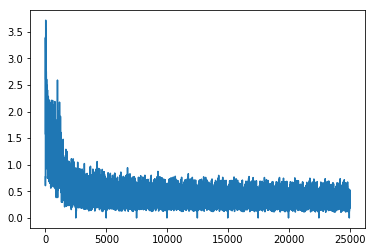

In [342]:
plt.plot(net.costs)

# Kaggle File Generation

In [346]:
predictionsTest = net.predict(test_x)

halfway point


In [352]:
generateCsv(predictionsTest, "FridayKaggle")

# 3) Visualization

In [228]:
correctIndices = []
incorrectIndices = []
for i in range(len(predictions)):
    if len(correctIndices)==5 and len(incorrectIndices)==5:
        print('hi')
        break
    if (predictions[i]==valid_y[i]):
        correctIndices.append(i)
    else:
        incorrectIndices.append(i)
    

# CORRECT PREDICTIONS

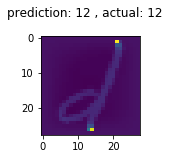

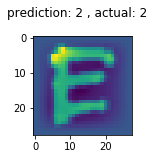

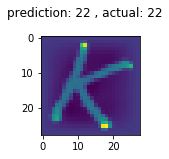

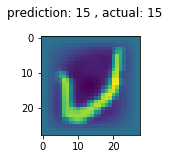

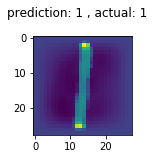

In [273]:
fig = plt.figure(1)
fig.suptitle('prediction: ' + str(predictions[correctIndices[0]]) + " , actual: " + str(valid_y[correctIndices[0]][0]))
plt.subplot(211)
plt.imshow(net.X[correctIndices[0], :-1].reshape(28,28))

fig = plt.figure(2)
fig.suptitle('prediction: ' + str(predictions[correctIndices[1]]) + " , actual: " + str(valid_y[correctIndices[1]][0]))
plt.subplot(211)
plt.imshow(net.X[correctIndices[1], :-1].reshape(28,28))

fig = plt.figure(3)
fig.suptitle('prediction: ' + str(predictions[correctIndices[2]]) + " , actual: " + str(valid_y[correctIndices[2]][0]))
plt.subplot(211)
plt.imshow(net.X[correctIndices[2], :-1].reshape(28,28))

fig = plt.figure(4)
fig.suptitle('prediction: ' + str(predictions[correctIndices[3]]) + " , actual: " + str(valid_y[correctIndices[3]][0]))
plt.subplot(211)
plt.imshow(net.X[correctIndices[3], :-1].reshape(28,28))

fig = plt.figure(5)
fig.suptitle('prediction: ' + str(predictions[correctIndices[4]]) + " , actual: " + str(valid_y[correctIndices[4]][0]))
plt.subplot(211)
plt.imshow(net.X[correctIndices[4], :-1].reshape(28,28))

# INCORRECT PREDICTIONS

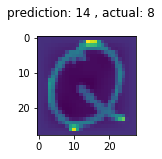

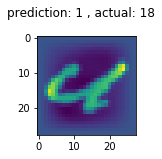

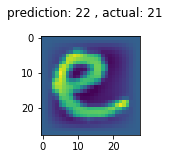

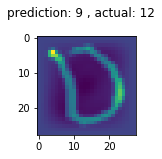

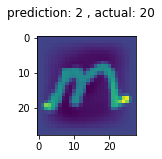

In [274]:
fig = plt.figure(1)
fig.suptitle('prediction: ' + str(predictions[incorrectIndices[0]]) + " , actual: " + str(valid_y[incorrectIndices[0]][0]))
plt.subplot(211)
plt.imshow(net.X[incorrectIndices[0], :-1].reshape(28,28))

fig = plt.figure(2)
fig.suptitle('prediction: ' + str(predictions[incorrectIndices[1]]) + " , actual: " + str(valid_y[incorrectIndices[1]][0]))
plt.subplot(211)
plt.imshow(net.X[incorrectIndices[1], :-1].reshape(28,28))

fig = plt.figure(3)
fig.suptitle('prediction: ' + str(predictions[incorrectIndices[2]]) + " , actual: " + str(valid_y[incorrectIndices[2]][0]))
plt.subplot(211)
plt.imshow(net.X[incorrectIndices[2], :-1].reshape(28,28))

fig = plt.figure(4)
fig.suptitle('prediction: ' + str(predictions[incorrectIndices[3]]) + " , actual: " + str(valid_y[incorrectIndices[3]][0]))
plt.subplot(211)
plt.imshow(net.X[incorrectIndices[3], :-1].reshape(28,28))

fig = plt.figure(5)
fig.suptitle('prediction: ' + str(predictions[incorrectIndices[4]]) + " , actual: " + str(valid_y[incorrectIndices[4]][0]))
plt.subplot(211)
plt.imshow(net.X[incorrectIndices[4], :-1].reshape(28,28))